# 0. Load Packages


In [1]:
from bisect import bisect_left
import sys
sys.path.append(r"C:\Users\jarra\Desktop\Masters\Heatwave_Project")
import pandas as pd
import PT13_Functions_For_Masters_New_Test as HW_Func
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
#RMSE 
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime


# 0.1 Data Involved

In [2]:
P_Gardens = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthgardens_daily_1880-1900.csv")
P_Gardens_Corr = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthgardens_daily_corrected_1880-1900.csv")

#Now we need to go back in time and minus 200 years off the date
#Convert To Datetime

P_Gardens['time'] = pd.to_datetime(P_Gardens['time'],format="%d/%m/%Y")
P_Gardens_Corr['time'] = pd.to_datetime(P_Gardens_Corr['time'],format="%d/%m/%Y")

#Split the Year up

P_Gardens = HW_Func.Date_Splitter(P_Gardens,'time',single= True)
P_Gardens_Corr = HW_Func.Date_Splitter(P_Gardens_Corr,'time',single= True)
P_Gardens['year'] = P_Gardens['year']-200
P_Gardens_Corr['year'] = P_Gardens_Corr['year']-200
#Combine in same format as ACORN-SAT

cols=["year","month","day"]
P_Gardens['date'] = P_Gardens[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
P_Gardens_Corr['date'] = P_Gardens_Corr[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

del P_Gardens['time']
del P_Gardens_Corr['time']
del P_Gardens['year']
del P_Gardens_Corr['year']
del P_Gardens['month']
del P_Gardens_Corr['month']
del P_Gardens['day']
del P_Gardens_Corr['day']

P_Gardens['date'] = pd.to_datetime(P_Gardens['date'],format="%Y/%m/%d")
P_Gardens_Corr['date'] = pd.to_datetime(P_Gardens_Corr['date'],format="%Y/%m/%d")

#Max Temp, (drop(0) has dropped the 0th index, so it starts at 1)
MaxT_Perth = pd.read_csv(r"C:\Users\jarra\Desktop\UPDATED TMAX, TMIN ACORN-SAT\tmax.009021.daily (3).csv").drop(0)
#Min Temp
MinT_Perth = pd.read_csv(r"C:\Users\jarra\Desktop\UPDATED TMAX, TMIN ACORN-SAT\tmin.009021.daily (2).csv").drop(0)
#Ave Temp
AvgT_Perth = (MaxT_Perth['maximum temperature (degC)']+MinT_Perth['minimum temperature (degC)'])/2

Maximum = pd.Series(MaxT_Perth['maximum temperature (degC)'], name="Max")
Minimum = pd.Series(MinT_Perth['minimum temperature (degC)'],name="Min")
Average = pd.Series(AvgT_Perth,name="Avg")

#The Daily Max Min Ave Data
ACORN_SAT = pd.concat([MaxT_Perth['date'],Maximum,Minimum,Average],axis=1)
ACORN_SAT['date'] = pd.to_datetime(ACORN_SAT['date'],format="%Y/%m/%d")



#Now load in and fix Perth Gardens 1830-1875
Per_Gard = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\swanriver_subdaily_1830-1875.csv")
Per_Gard
#Set Datetime
Per_Gard['date'] = pd.to_datetime(Per_Gard['date'],dayfirst = True)
    

#So this works, now we need to expand this into a for loop and make this a new dataframe to be added onto
#the historical time because it will make things easier



#Can't set index yet.
#Perth Regional Office 1967 to 1992 sub daily dataset
PRO_Sub = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\perthregionaloffice_subdaily_1942-1992.csv")

PRO_Sub['date'] = pd.to_datetime(PRO_Sub['date'],dayfirst = True)
PRO_Sub = PRO_Sub.set_index('date')
PRO_Sub =PRO_Sub['temp']/10 

PRO_Sub_ES  = PRO_Sub.loc['1967':'1992']
PRO_Sub_ES =PRO_Sub_ES

## Perth Regional Office Daily Extreme Dataset
#Load PRO in
#BOM PERTH REGIONAL OFFICE
MaxT_PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\IDCJAC0010_009034_1800_Data.csv")
MinT_PRO = pd.read_csv(r"E:\LIBRARY\UNIVERSITY\Masters Research\Python\Data\IDCJAC0011_009034_1800_Data.csv")

#Clean The data
MaxT_PRO['Datetime']= pd.to_datetime(MaxT_PRO[['Year', 'Month', 'Day']])
MinT_PRO['Datetime']= pd.to_datetime(MinT_PRO[['Year', 'Month', 'Day']])

#Delete irrelevent columns
del MaxT_PRO['Product code']
del MaxT_PRO['Bureau of Meteorology station number']
del MaxT_PRO['Year']
del MaxT_PRO['Month']
del MaxT_PRO['Day']
del MaxT_PRO['Days of accumulation of maximum temperature']
del MaxT_PRO['Quality']
del MinT_PRO['Product code']
del MinT_PRO['Bureau of Meteorology station number']
del MinT_PRO['Year']
del MinT_PRO['Month']
del MinT_PRO['Day']
del MinT_PRO['Days of accumulation of minimum temperature']
del MinT_PRO['Quality']

#Change the column name to date
MaxT_PRO= MaxT_PRO.rename(columns={'Datetime':'date'})
MinT_PRO= MinT_PRO.rename(columns={'Datetime':'date'})


#Change the column names
MaxT_PRO= MaxT_PRO.rename(columns={'Maximum temperature (Degree C)':'PRO Max'})
MinT_PRO= MinT_PRO.rename(columns={'Minimum temperature (Degree C)':'PRO Min'})

#Now concat it
MaxT_PRO= MaxT_PRO.set_index('date')
MinT_PRO= MinT_PRO.set_index('date')

PRO_DE = pd.merge(left = MaxT_PRO,right  =MinT_PRO,left_index=True,right_index=True  )

#Training Data
PRO_DE_Training = PRO_DE.loc['1967':'1992']
PRO_Sub_Training = PRO_Sub_ES
#Estimating Data
PRO_Sub_4_Est = PRO_Sub.reset_index()


In [3]:
T_Ext =PRO_DE_Training.reset_index()
T_Sub =PRO_Sub_ES.reset_index()
S_Est = PRO_Sub_4_Est
S_Est

,date,temp
0,1942-01-01 09:00:00,23.0
1,1942-01-01 15:00:00,26.4
2,1942-01-01 21:00:00,21.9
3,1942-01-02 09:00:00,24.1
4,1942-01-02 15:00:00,25.6
...,...,...
134523,1992-04-28 09:00:00,18.0
134524,1992-04-28 15:00:00,22.7
134525,1992-04-29 09:00:00,19.6
134526,1992-04-29 15:00:00,23.0


# 01. Core Function


In [25]:
def Temp_Estimation(Sub_Daily, Sub_Daily_Training,Daily_Extreme_Training, Trials, Sim_Comp):
    '''
    Parameters
    --------------
    Sub_Daily : DataFrame
        This is the raw subdaily data you aim to estimate the maximum and minimum temperatures from.
    
    Sub_Daily_Training : DataFrame
        A list with the date and temp as 2 columns and index going from 0,1...X. All values are subdaily so they have hours
        associated with them also time is in 24 hour format.
        
    Daily_Extreme_Training : DataFrame
        A list with the date and temp as 3 columns and index going from 0,1...X. All values are daily with max and min
        associated with them also time is in 24 hour format.
     
    Trials : Integer
        The number of trails you want to run the estimation training over.
    
    Sim_Comp : 
    '''
    
    
    
    # Part 1: Split the Sub_Daily Training into individual hours ane combine
    Sub_Max, Sub_Min, Hours_Avaliable = Sub_Daily_Splitter(Sub_Daily_Training)
    
    # Part 2: Concat the Maximum and Minimum Data to the subdaily data
    Sub_Ext_Max, Sub_Ext_Min = concat_max_sub(Sub_Max, Sub_Min, Hours_Avaliable, Daily_Extreme_Training)
    
    #Now Every Single Available hour and max and min is ready to be used.
    #Part 3: Split into each respective Month and add all together so its like Month_Hour_Mx/Mn
    Monthly_Split_Dic = Month_Splitter(Hours_Avaliable,Sub_Ext_Max, Sub_Ext_Min)
    
    #Include 24 in the hours avalaible, this is to get it back to 0
    Hours_Avaliable_Inc_24 = Hours_Avaliable.copy()
    Hours_Avaliable_Inc_24.append(24)
    
    #PART 4 Is to fix up the Historical Data so it is closest to the every hour hour mark where data is avaliable
    Sub_Daily = Closest_Hour(Sub_Daily, Hours_Avaliable_Inc_24)
    
    #PART 5 Is to sample by the length of the number of datapoints for that month and max or min
    #Now I need to select 600 points and trail it 1000 times for each single thing in the dictionary and label the hour 0 as hour 0 run 1]
    #and PRO Max Run 1
    Sampled = Sampler_Trainer(Monthly_Split_Dic,Trials)
    
    #Part 6
    #Now to apply the regression anaylsis onto the data I have provide
    Linear_Analysis = Linear_Regression_Analysis(Trials, Hours_Avaliable, Sampled)
    
    #Part 7    
    #Get the data into their respective max and min with the hours matching the regression data, look at the explabations
    #above in Part 2 and Part 7 for more information
    Max_Data = Max_Sub(Sub_Daily)
    
    Min_Data= Min_Sub(Sub_Daily)
    
    #Part 8 Temperature Estimation
    Full_Temperature_Estimation= Tmax_Tmin_All_Data_Est(Trials, Max_Data, Min_Data, Linear_Analysis)
    
    #Part 9 The Best Temperature Estimation
    Temperature_Estimation = Absolute_Estimation(Full_Temperature_Estimation, Trials, Sim_Comp)
    
    return(Temperature_Estimation)


A = Temp_Estimation(S_Est, T_Sub,T_Ext,1, False)
B = Temp_Estimation(S_Est, T_Sub,T_Ext,1, True)

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-01-05  20.6            21            16.778899           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-01-21  21.4            21            17.323555           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-01-31  18.8             9            14.948051           0.867518
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-03-03  15.0             9            12.438095            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-03-05  16.0             9            13.255372            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-03-06  19.9             9            16.442752            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1942-03-11  21.2             9            17.5052

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-01  12.8             6            12.816783           0.982589
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-02  16.1            21            13.715207           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-05  15.7             3            14.696014           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-12  11.9             6            11.982221           0.982589
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-23  18.4             3            17.043551           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-29  18.4             3            17.043551           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-01-31  12.8             6            12.8167

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-08-19   9.8             3             8.411392           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-09-02   7.6             3             6.608507           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-09-15  10.1             3             8.815557           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-09-16  10.6             3             9.256967           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-09-17  13.4             9             9.544594           0.767002
1 1943-09-17  14.2            18             9.164171           0.619623
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1943-09-20   5.6             6             5.618906           0.960952
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1944-09-07   5.0             6             5.091618           0.960952
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1944-09-10   9.3             0             6.997207           0.872870
1 1944-09-10   8.6             3             7.491327           0.925148
2 1944-09-10   9.3             9             6.303861           0.767002
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1944-09-11   9.4             3             8.197583           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1944-10-11  14.4             0            11.788581            0.90945
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1944-10-21  10.4             3             9.286107            0.95695
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1944-10-29  16.1             0            13.4007

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1945-09-10  11.0            12             7.155430           0.623621
1 1945-09-10  12.3            18             8.028893           0.619623
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1945-09-19   5.6             3             4.842868           0.925148
1 1945-09-19   5.6             6             5.618906           0.960952
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1945-09-21   9.5             3             8.285865           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1945-09-22  10.4             9             7.173326           0.767002
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1945-09-28   5.0             6             5.091618           0.960952
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1945-10-05  13.9             0             11.314

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1946-10-02  11.7             9             8.411919           0.736672
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1946-10-15  14.4             0            11.788581           0.909450
1 1946-10-15  14.6             9            10.430240           0.736672
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1946-10-24  15.1             3            13.626946            0.95695
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1946-11-01  15.0             0            12.834675           0.877047
1 1946-11-01  17.7             3            16.192224           0.963439
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1946-11-11  14.0             3            12.809903           0.963439
1 1946-11-11  14.1             9            11.114146           0.773693
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1947-09-08  12.9             0            10.215925           0.872870
1 1947-09-08  13.3             3            11.640581           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1947-09-12   9.4             3             8.197583           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1947-09-14   3.9             6             4.124925           0.960952
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1947-09-15   9.4             9             6.382904           0.767002
1 1947-09-15  10.2            12             6.760383           0.623621
2 1947-09-15   9.1            21             5.465644           0.804844
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1947-09-20  12.4             0             9.768881           0.872870
1 1947-09-20  13.0            21             8.9162

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1948-04-28  17.2             0            14.408038           0.894770
1 1948-04-28  17.9             3            16.233179           0.953148
2 1948-04-28  16.7             9            13.331990           0.871216
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1948-04-29  16.1             0            13.392263            0.89477
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1948-06-03  10.7             9             8.231086            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1948-06-06  11.7             9             9.168194            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1948-06-11  11.1             9             8.605929            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1948-06-12  13.9             9             11.229

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1952-07-05   8.3             0             6.089068           0.887624
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1952-07-06  10.2             0             7.837482           0.887624
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1952-07-14   5.1             3             4.307549            0.92829
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1952-07-15   6.6             0             4.524697           0.887624
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1952-07-18   8.2             0             5.997046           0.887624
1 1952-07-18   8.8             9             6.547952           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1952-07-26  10.0             0             7.653439           0.887624
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1953-03-10  20.6             9            17.014846            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1953-03-18  19.1             9             15.78893            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1953-03-24  22.6             0            19.161786           0.891879
1 1953-03-24  22.2             3            20.218507           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1953-04-03  10.8             3             9.564365           0.953148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1953-04-06  14.0             9            10.897627           0.871216
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1953-04-18  17.9             9            14.413929           0.871216
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1954-03-12  18.2             0            15.597246           0.891879
1 1954-03-12  17.4             3            15.946738           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1954-03-25  16.2             0            13.977001           0.891879
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1954-03-27  17.2             9            14.236104            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1954-04-27   5.1             6             5.157294           0.966806
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1954-04-30  10.6             3             9.376511           0.953148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1954-05-13   6.9             6             7.096513            0.94557
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1955-02-19  25.7            12            17.907195           0.760275
1 1955-02-19  24.6            18            17.804804           0.760318
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1955-03-17  21.7             3            19.773531           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1955-03-21  16.2             3            14.878796           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1955-03-23  21.4             9            17.668668            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1955-04-01  16.2             9            12.881182           0.871216
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1955-04-06  19.4             9            15.766352           0.871216
1 1955-04-06  20.2            12            13.2997

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-01-20  23.4             3            21.390842           0.967349
1 1956-01-20  23.4             9            18.533939           0.867518
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-01-21  23.8             3            21.738625           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-02-06  21.9             3            20.116103           0.960786
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-02-07  20.3             0            17.548247           0.859379
1 1956-02-07  20.6             3            18.958172           0.960786
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-02-17  18.2             3            16.820452           0.960786
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-03-02  26.1            12            17.6468

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-08-26   5.3             6             5.346326           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-08-31   4.2             6             4.447024           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-09-01   9.5             9             6.461946           0.767002
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-09-03  10.3             0             7.891295           0.872870
1 1956-09-03  10.6             3             9.256967           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-09-05   3.9             3             3.342074           0.925148
1 1956-09-05   3.8             6             4.037043           0.960952
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1956-09-05   3.8             6             4.0370

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1957-12-31  19.0             3            17.577047           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1958-01-15  23.3             3            21.303896           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1958-02-16  19.6             3            18.067455           0.960786
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1958-04-16  14.8             0            12.191802            0.89477
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1958-04-29  14.8             3            13.321443           0.953148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1958-05-26   7.8             6             7.845538            0.94557
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1958-05-29  14.7             9            11.6771

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1959-06-07   9.8             0             7.475681           0.896701
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1959-06-09   9.6             9             7.200268            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1959-07-19  14.3             9             11.53255           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1959-07-23  10.6             9             8.179275           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1959-07-24  12.4             9             9.810598           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1959-08-01  13.9             0            11.221901           0.880886
1 1959-08-01  13.9             9            10.565100           0.855954
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1960-06-14   5.0             3             4.286434           0.936953
1 1960-06-14   5.0             6             5.186147           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1960-06-15   4.8             6             5.023876           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1960-06-16   8.8             9             6.450582            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1960-06-26  12.1             9             9.543037            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1960-06-29   4.8             6             5.023876           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1960-07-03   8.9             3             7.598451            0.92829
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-05-18  14.4             9            11.398461           0.872629
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-05-29  10.7             3             9.580799           0.932675
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-05-31  12.2             9             9.354678           0.872629
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-06-02  10.1             3             8.747314           0.936953
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-06-03  13.6             9            10.948698            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-06-05  13.9             9             11.22983            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1961-06-07  13.6             9            10.9486

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-08-03  12.2             3             10.50429           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-08-07  11.3             9             8.141869           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-08-17   4.3             6             4.528778           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-08-18   5.7             3             4.836025           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-08-27  11.1             9             7.955466           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-09-02  14.6             0            11.735875            0.87287
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1962-09-09  11.2             3             9.7866

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-07-23  11.4             9             8.904308           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-08-02  11.1             9             7.955466           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-08-08  10.6             3             9.109025           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-08-21  10.4             0             7.948042           0.880886
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-08-22  11.1             0             8.602814           0.880886
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-08-31  13.4             9            10.099094           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1963-09-03  10.7             3             9.3452

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1964-07-22  10.6             9             8.179275           0.864973
1 1964-07-22  12.0            21             8.295910           0.795374
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1964-07-25  13.1            21             9.368712           0.795374
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1964-07-28  12.8             9            10.173114           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1964-08-01  14.9             9            11.497112           0.855954
1 1964-08-01  15.2            18             9.609280           0.611851
2 1964-08-01  13.9            21             9.921720           0.809727
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1964-08-08   6.2             3             5.272046           0.935188
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1965-07-17  12.1            21             8.393437           0.795374
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1965-07-18  12.2             0             9.677919           0.887624
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1965-07-27   7.8             3             6.645822            0.92829
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1965-07-28  10.2             9             7.816759           0.864973
1 1965-07-28   9.8            21             6.150304           0.795374
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1965-07-30  10.9             3             9.330505            0.92829
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1965-08-01   8.7             9             5.718638           0.855954
1 1965-08-01  10.8            18             6.3901

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-03-11  14.2             3            13.098892           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-03-13  16.3             0            14.058013           0.891879
1 1966-03-13  17.2             3            15.768748           0.956628
2 1966-03-13  16.4             9            13.582282           0.894860
3 1966-03-13  16.3            21            13.052058           0.852355
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-03-20  18.3             9            15.135109            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-03-22  20.4             9             16.85139            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-04-02  12.8             3            11.442904           0.953148
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-11-12  16.1            21            12.636672           0.817886
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-11-24  13.3             3            12.170004           0.963439
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-12-14  18.5            21            15.107194           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1966-12-19  18.5             3            17.125295           0.962419
1 1966-12-19  19.1            21            15.527255           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1967-01-01  19.2            21             15.82575           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1967-01-03  17.7             3             16.43493           0.967349
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1967-12-28  16.7             3            15.498988           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1967-12-30  20.0            21            16.157346           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1967-12-31  18.3             3            16.944595           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-01-02  17.9             3            16.608822           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-01-05  19.5             0            16.879369           0.889754
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-01-13  26.1            21            20.523411           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-01-24  20.2            21            16.5065

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-08-03   4.5             6             4.692288           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-08-04   5.0             6             5.101062           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-08-05   9.3             9             6.277845           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-08-06  12.3             9             9.073881           0.855954
1 1968-08-06  13.0            21             9.067882           0.809727
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-08-16   9.4             3             8.062576           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1968-08-20   4.7             6             4.855797           0.948935
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1969-07-25  11.9             0             9.401853           0.887624
1 1969-07-25  11.0             3             9.417108           0.928290
2 1969-07-25  10.7             9             8.269904           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1969-07-31  14.0             9            11.260663           0.864973
1 1969-07-31  14.7            21            10.929153           0.795374
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1969-08-05   4.2             6             4.447024           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1969-08-06   7.9             9             4.973028           0.855954
1 1969-08-06   8.3            21             4.608950           0.809727
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1969-08-10   5.4             6             5.4280

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1970-12-13  15.2             3            14.143733           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1970-12-14  18.2            21            14.897163           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1970-12-19  19.5            21            15.807295           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1970-12-28  21.8             9            16.507361           0.802705
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1970-12-29  21.7            21            17.347519           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1971-01-11  16.1             3            15.043797           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1971-01-15  18.7             3            17.3043

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1971-12-26  13.3             3            12.427076           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1972-01-01  25.9             3            23.564487           0.967349
1 1972-01-01  26.1             9            20.638700           0.867518
2 1972-01-01  24.2            21            19.229852           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1972-02-09  20.4             3            18.780029           0.960786
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1972-03-05  26.7             3            24.223291           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1972-03-12  23.8             9            19.630132            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1972-03-25  12.3             3            11.4079

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1973-06-03   9.8             9              7.38769            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1973-06-05  12.9            12             7.679394           0.564635
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1973-06-06  13.8             0            11.325877           0.896701
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1973-06-20   9.7             9             7.293979            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1973-06-21  12.9             9            10.292723           0.888460
1 1973-06-21  13.5            12             8.074396           0.564635
2 1973-06-21  13.8            18             8.701448           0.631723
3 1973-06-21  12.8            21             9.234770           0.829119
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1974-05-24  11.8             9             8.983081           0.872629
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1974-05-26  10.5             9             7.775391           0.872629
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1974-05-27   9.5             3             8.556509           0.932675
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1974-05-30  14.4             9            11.398461           0.872629
1 1974-05-30  14.0            21            10.136681           0.831365
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1974-05-31  17.1             0            14.300154           0.873104
1 1974-05-31  17.4             9            14.185438           0.872629
2 1974-05-31  17.4            12            11.278899           0.529358
3 1974-05-31  16.5            18            11.0685

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1975-05-21   7.4             6             7.512638            0.94557
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1975-05-22   7.3             6             7.429413            0.94557
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1975-05-23  11.3             9             8.518584           0.872629
1 1975-05-23  10.4            21             6.697278           0.831365
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1975-05-26  16.5             9            13.349345           0.872629
1 1975-05-26  14.7            21            10.805454           0.831365
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1975-05-30  11.6             9             8.797282           0.872629
1 1975-05-30  15.0            21            11.092071           0.831365
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1976-04-28  19.6             3            17.829937           0.953148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1976-05-28  14.0             9            11.026864           0.872629
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1976-05-31   4.5             6             5.099114            0.94557
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1976-06-01   5.5             6             5.591825           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1976-06-02   8.6             9             6.263161           0.888460
1 1976-06-02   9.6            21             6.072015           0.829119
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1976-06-13  11.4             9             8.887062            0.88846
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1977-09-25  13.4             0            10.662969            0.87287
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1977-10-01  14.0             0            11.409244           0.909450
1 1977-10-01  14.2            15             9.281196           0.705491
2 1977-10-01  13.5            21             9.871942           0.819026
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1977-10-02  14.3             0            11.693747            0.90945
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1977-10-05  15.0            21             11.09942           0.819026
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1977-10-08  12.0             3            10.763839            0.95695
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1977-10-09  16.1             0            13.4007

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1978-09-22  11.4             3             9.963223           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1978-11-20  20.4            21            15.855263           0.817886
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1978-12-03  14.6             3             13.60163           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1978-12-04  18.9             0            16.234935           0.870119
1 1978-12-04  19.5            18            14.803894           0.736910
2 1978-12-04  17.8            21            14.617123           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1978-12-05  20.0            21            16.157346           0.792842
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1978-12-06  26.7             0            22.6859

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1979-10-22  12.5             3            11.225631            0.95695
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1979-11-09  16.2             0            13.811668           0.877047
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1979-11-19  12.6             3            11.530106           0.963439
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1979-12-05  18.5             3            17.125295           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1979-12-06  13.5             3            12.607776           0.962419
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1979-12-09  18.7             0            16.069524           0.870119
1 1979-12-09  18.4             3            17.034945           0.962419
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1980-06-29   9.4            21             5.874343           0.829119
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1980-07-08  12.4             9             9.810598           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1980-07-12   8.5             9             6.276065           0.864973
1 1980-07-12   9.3            18             5.156315           0.607996
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1980-07-20   7.2             3             6.126205            0.92829
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1980-07-26  10.2             9             7.816759           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1980-07-29  10.0             9             7.635501           0.864973
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1981-07-20   9.8             9             7.454243           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1981-07-23   8.3             9             6.094807           0.864973
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1981-08-06  13.8             9            10.471899           0.855954
1 1981-08-06  13.0            21             9.067882           0.809727
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1981-08-09  12.4             9             9.167082           0.855954
1 1981-08-09  12.8            21             8.878140           0.809727
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1981-08-13  11.3             9             8.141869           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1981-08-15  13.0             0            10.3800

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1982-08-02   7.7             3             6.580107           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1982-08-15  12.0             9             8.794277           0.855954
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1982-09-04  10.6             3             9.256967           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1982-09-12  15.2             0            12.272328           0.872870
1 1982-09-12  14.3             3            12.523401           0.925148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1982-09-13  13.4             0            10.662969            0.87287
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1982-09-19  15.5             9            11.204482           0.767002
1 1982-09-19  14.3            21            10.0663

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1983-12-29  20.5             9            15.613001           0.802705
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1984-01-06  18.2             0            15.832226           0.889754
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1984-01-14  18.7             9            14.870097           0.867518
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1984-01-17  20.3             3            18.695521           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1984-01-18  22.4             0            19.215304           0.889754
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1984-01-30  26.0            12            17.800156           0.808964
1 1984-01-30  29.4            15            19.539385           0.826809
2 1984-01-30  29.4            18            20.5606

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1985-02-13  27.5             9            22.081053           0.862222
1 1985-02-13  28.7            21            22.415847           0.766188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1985-02-16  21.6             9            17.718304           0.862222
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1985-02-17  25.5             9            20.602155           0.862222
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1985-02-23  24.2             9            19.640871           0.862222
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1985-03-04  21.4             9            17.668668            0.89486
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1985-03-10  17.0             3            15.590757           0.956628
        date  temp  Closest Hour  Min Temp Estimati

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-03-14  17.3             0            14.868136           0.891879
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-03-15  19.5            21            15.568611           0.852355
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-03-26  19.3             3            17.637647           0.956628
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-03-30  17.7            21             14.15305           0.852355
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-04-02  16.3             9            12.971343           0.871216
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-04-07  15.3             3            13.791078           0.953148
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1986-04-12  17.8            21            13.6469

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1987-07-30  11.6             9             9.085566           0.864973
1 1987-07-30  10.6            21             6.930524           0.795374
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1987-08-01   4.0             6             4.283514           0.948935
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1987-08-26   7.5             3             6.405699           0.935188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1987-10-04  16.2             9            11.543796           0.736672
1 1987-10-04  16.0            21            11.917739           0.819026
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1987-10-11  15.1            21            11.181252           0.819026
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1987-11-21  16.1             0            13.7302

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1989-01-17  22.8            21            18.276704           0.807658
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1989-01-18  24.3             3            22.173354           0.967349
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1989-02-25  19.2             0            16.717802           0.859379
1 1989-02-25  19.4             3            17.889312           0.960786
2 1989-02-25  19.2             9            15.943626           0.862222
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1989-02-26  19.4            12            14.678603           0.760275
1 1989-02-26  19.0            18            14.695317           0.760318
2 1989-02-26  19.1            21            15.806901           0.766188
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1989-03-03  22.1            21            17.6133

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-06-21   6.6             3             5.685926           0.936953
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-06-24   4.2             6             4.537062           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-06-26   4.6             6             4.861604           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-06-27   3.8             6             4.212519           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-06-29   2.9             6             3.482298           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-06-30   3.7             6             4.131384           0.953244
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1990-07-01   4.1             6             4.2228

        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-06-14  11.9             9             9.355615            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-06-19  11.5            21             7.949901           0.829119
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-06-21  12.5             9              9.91788            0.88846
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-06-26  13.3            21              9.72895           0.829119
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-07-02  13.9             0            11.242289           0.887624
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-07-07   3.5             6             3.738099           0.931955
        date  temp  Closest Hour  Min Temp Estimation  Correlation Min T
0 1991-07-08   5.7             9             3.7384

In [4]:
B = Temp_Estimation(S_Est, T_Sub,T_Ext,1, True)

NameError: name 'S_Est' is not defined

In [26]:
T1 = A.get('Trial_1')
T2 = B.get('Trial_1')
PRO_DE

,PRO Max,PRO Min
date,,
1897-01-01,30.6,19.4
1897-01-02,29.4,17.8
1897-01-03,27.8,18.3
1897-01-04,31.7,14.4
1897-01-05,36.7,16.1
...,...,...
1992-04-25,29.6,15.7
1992-04-26,30.0,19.5
1992-04-27,22.4,15.7


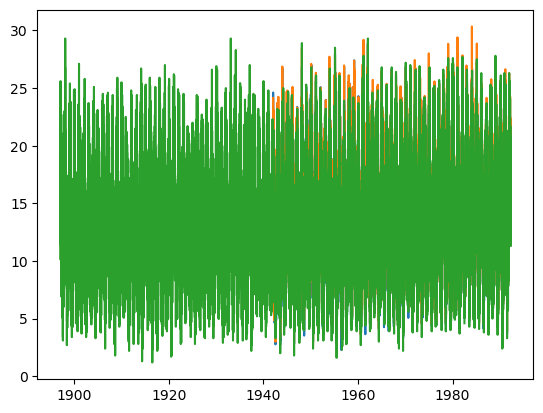

In [27]:
plt.plot(T1['Min Temp Estimation'])
plt.plot(T2['Min Temp Estimation'])
plt.plot(PRO_DE['PRO Min'])

In [31]:
print('All Data TMAX')

actualmx = PRO_DE['PRO Max'].loc['1942-01-01':'1992-04-29']
predmx = T1['Max Temp Estimation'].loc['1942-01-01':'1992-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))
print('Complex')
print(RMSEMx)
Diff = (predmx - actualmx).mean()
print(Diff)
print('-------')

actualmx = PRO_DE['PRO Max'].loc['1942-01-01':'1992-04-29']
predmx = T2['Max Temp Estimation'].loc['1942-01-01':'1992-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))
print('Simple')
print(RMSEMx)
Diff = (predmx - actualmx).mean()
print(Diff)
print('-------')

print('1942-1962')
actualmx = PRO_DE['PRO Max'].loc['1942-01-01':'1962-04-29']
predmx = T1['Max Temp Estimation'].loc['1942-01-01':'1962-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))
print('Complex')
print(RMSEMx)
Diff = (predmx - actualmx).mean()
print(Diff)
print('-------')

actualmx = PRO_DE['PRO Max'].loc['1942-01-01':'1962-04-29']
predmx = T2['Max Temp Estimation'].loc['1942-01-01':'1962-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))
print('Simple')
print(RMSEMx)
Diff = (predmx - actualmx).mean()
print(Diff)
print('-------')

print('1962-1992')

actualmx = PRO_DE['PRO Max'].loc['1962-01-01':'1992-04-29']
predmx = T1['Max Temp Estimation'].loc['1962-01-01':'1992-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))
print('Complex')
print(RMSEMx)
Diff = (predmx - actualmx).mean()
print(Diff)
print('-------')

actualmx = PRO_DE['PRO Max'].loc['1962-01-01':'1992-04-29']
predmx = T2['Max Temp Estimation'].loc['1962-01-01':'1992-04-29']
Maximum = pd.concat([actualmx,predmx], axis =1).dropna()
RMSEMx = sqrt(mean_squared_error(Maximum['PRO Max'], Maximum['Max Temp Estimation']))
print('Simple')
print(RMSEMx)
Diff = (predmx - actualmx).mean()
print(Diff)
print('-------')


All Data TMAX
Complex
1.0235836504767666
0.4662866724335611
-------
Simple
1.1687575259796539
0.02920096725193053
-------
1942-1962
Complex
1.0819475190721544
0.49446539554761915
-------
Simple
1.1945500512436933
0.07401497806227182
-------
1962-1992
Complex
0.9821899261415825
0.44819883290568646
-------
Simple
1.1514563857563578
0.0010534796297952877
-------


In [32]:
print('All Data')
actualmn = PRO_DE['PRO Min'].loc['1942-01-01':'1992-04-29']
predmn = T1['Min Temp Estimation'].loc['1942-01-01':'1992-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))
print('Complex')
print(RMSEMn)
Diff = (predmn - actualmn).mean()
print(Diff)
print('-------')

actualmn = PRO_DE['PRO Min'].loc['1942-01-01':'1992-04-29']
predmn = T2['Min Temp Estimation'].loc['1942-01-01':'1992-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))
print('Simple')

print(RMSEMn)
Diff = (predmn - actualmn).mean()
print(Diff)
print('-------')

print('1942-1962')
actualmn = PRO_DE['PRO Min'].loc['1942-01-01':'1962-04-29']
predmn = T1['Min Temp Estimation'].loc['1942-01-01':'1962-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))

print('Complex')
print(RMSEMn)
Diff = (predmn - actualmn).mean()
print(Diff)
print('-------')

actualmn = PRO_DE['PRO Min'].loc['1942-01-01':'1962-04-29']
predmn = T2['Min Temp Estimation'].loc['1942-01-01':'1962-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))
print('Simple')
print(RMSEMn)
Diff = (predmn - actualmn).mean()
print(Diff)
print('-------')

print('1962-1992')
actualmn = PRO_DE['PRO Min'].loc['1962-01-01':'1992-04-29']
predmn = T1['Min Temp Estimation'].loc['1962-01-01':'1992-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))
print('Complex')
print(RMSEMn)
Diff = (predmn - actualmn).mean()
print(Diff)
print('-------')

actualmn = PRO_DE['PRO Min'].loc['1962-01-01':'1992-04-29']
predmn = T2['Min Temp Estimation'].loc['1962-01-01':'1992-04-29']
Minimum = pd.concat([actualmn,predmn], axis =1).dropna()
RMSEMn = sqrt(mean_squared_error(Minimum['PRO Min'], Minimum['Min Temp Estimation']))
print('Simple')
print(RMSEMn)
Diff = (predmn - actualmn).mean()
print(Diff)
print('-------')


All Data
Complex
2.173469680287705
-0.18240689950246758
-------
Simple
2.451491301781881
0.2513829328766422
-------
1942-1962
Complex
2.021516365940304
0.15299856701050527
-------
Simple
2.301276617266366
0.5600318684808917
-------
1962-1992
Complex
2.2689125834464403
-0.4045289852392927
-------
Simple
2.5464082492421336
0.04566419353472655
-------


### All Data

RMSE

2.1788581660527937

MEAN DIF OBSERVE - ESTIMATED

-0.165377988583119

-------

2.4558149115501577

0.24353437788586618


-------

### 1942-1962

2.034281042565149

0.18031951354528136

-------

2.302497689804424

0.5435511213715878

-------

### 1962-1992

2.2697273055266103

-0.39445136773750417

-------

2.5525800283463616

0.043628751927303325


-------

In [33]:
#Plot T
#1830-1875 resample
PRO_1 = T1.resample('Y').mean().reset_index()
PRO_2 = T2.resample('Y').mean().reset_index()

#PRO DE
PRO_DE_Y = PRO_DE.resample('Y').mean().reset_index()

#ACORN_SAT
ACORN_SAT_Y = ACORN_SAT.set_index('date').resample('Y').mean().reset_index()

#P_Gardens|
P_Gardens_Y =  P_Gardens.set_index('date').resample('Y').mean().reset_index()

P_Gardens_CORR_Y = P_Gardens_Corr.set_index('date').resample('Y').mean().reset_index()

Text(0.5, 1.0, 'Average Yearly Maximum Temperature')

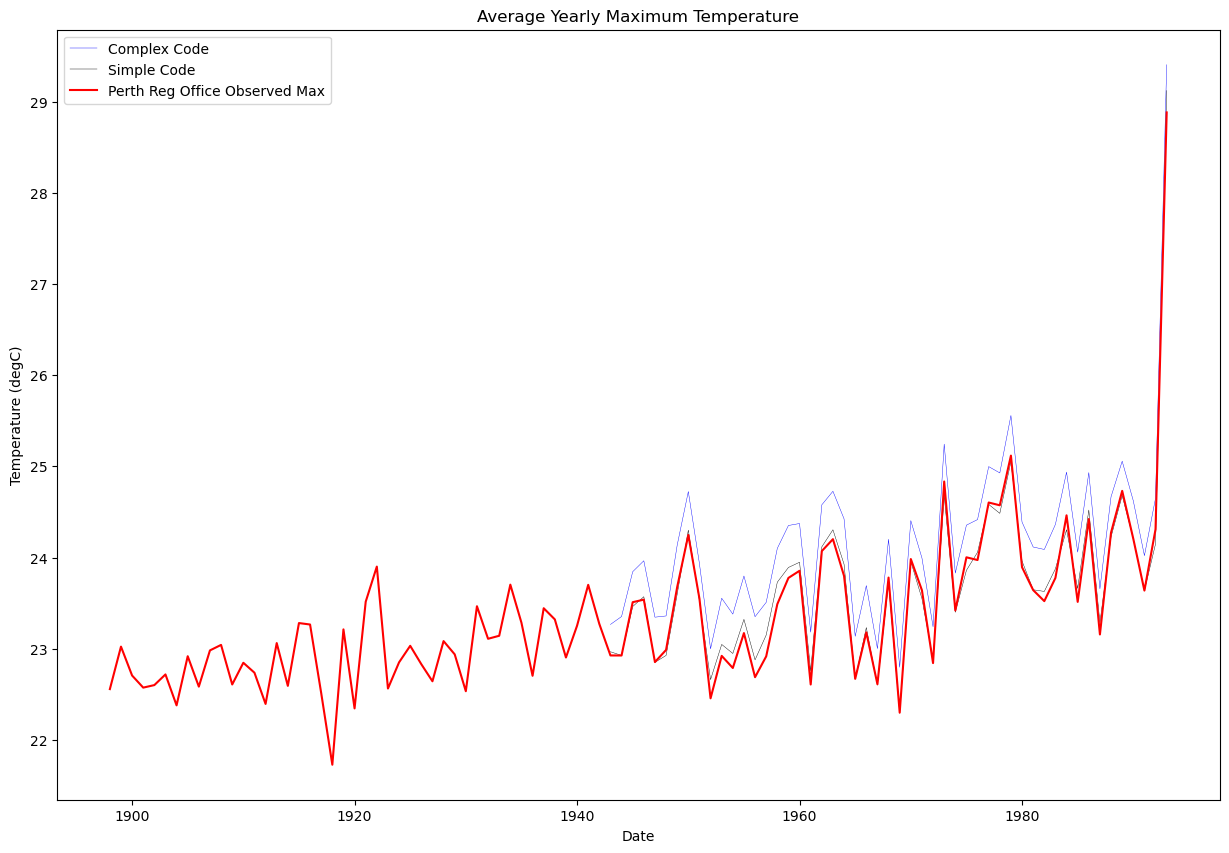

In [36]:
plt.figure(1,figsize= [15,10])
#Historical Estimation


#Current Estimation
plt.plot(PRO_1['date'],PRO_1['Max Temp Estimation'],linewidth=0.3,label = 'Complex Code',color = 'blue')

plt.plot(PRO_2['date'],PRO_2['Max Temp Estimation'],linewidth=0.3,label = 'Simple Code',color = 'black')



#PRO DE
plt.plot(PRO_DE_Y['date'],PRO_DE_Y['PRO Max'],linewidth=1.5,label = 'Perth Reg Office Observed Max',color = 'red')

#ACORN_SAT
#plt.plot(ACORN_SAT_Y['date'],ACORN_SAT_Y['Max'],linewidth=1.5,label = 'ACORN-SAT Max',color = 'green')

#Perth Gardens
#plt.plot(P_Gardens_Y['date'],P_Gardens_Y['tmax'],linewidth=1.5,label = 'Perth Gardens Uncorrected Max',color = 'cyan')

#plt.plot(P_Gardens_CORR_Y['date'],P_Gardens_CORR_Y['tmax'],linewidth=1.5, label = 'Perth Gardens Corrected Max',color = 'orange')

plt.legend()

plt.ylabel('Temperature (degC)')
plt.xlabel('Date')
plt.title('Average Yearly Maximum Temperature')

Text(0.5, 1.0, 'Average Yearly Minimum Temperature')

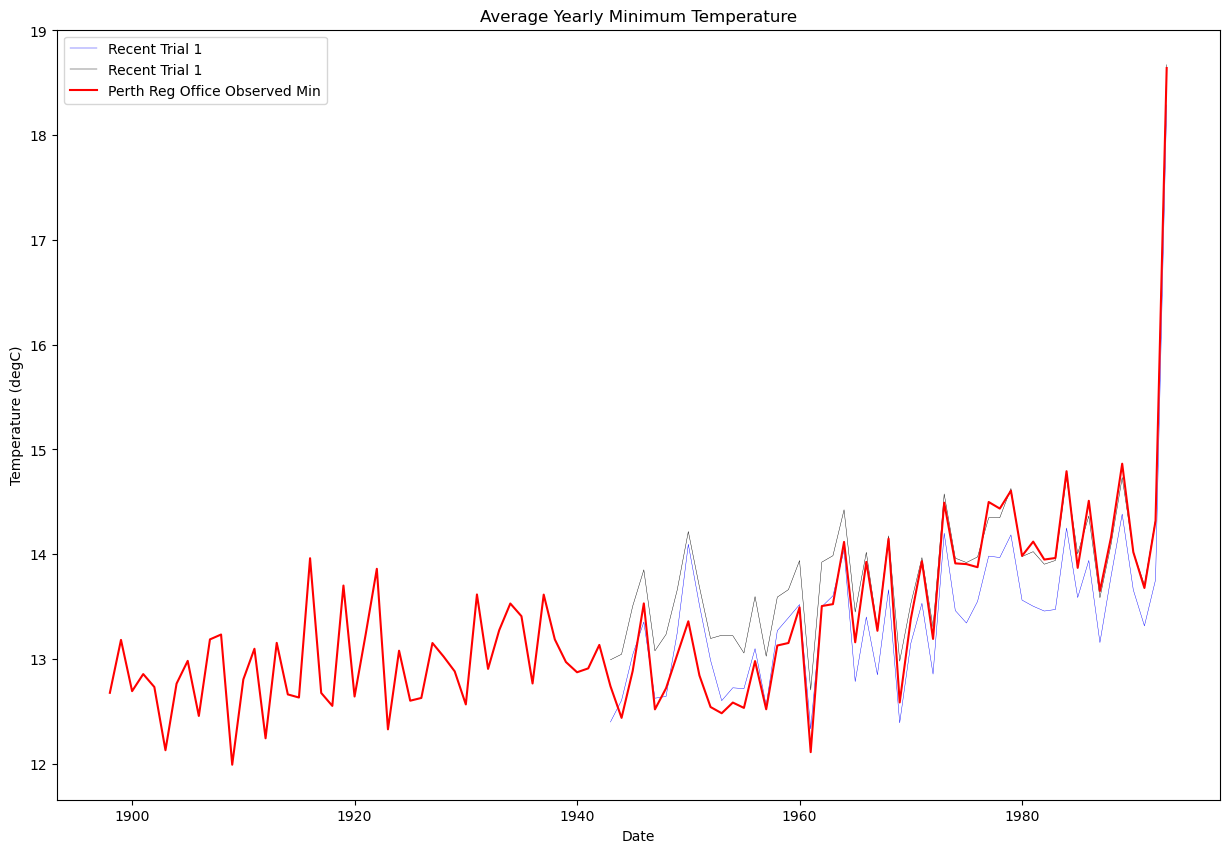

In [35]:
plt.figure(1,figsize= [15,10])
#Historical Estimation


#Current Estimation
plt.plot(PRO_1['date'],PRO_1['Min Temp Estimation'],linewidth=0.3,label = 'Recent Trial 1',color = 'blue')
#Current Estimation
plt.plot(PRO_2['date'],PRO_2['Min Temp Estimation'],linewidth=0.3,label = 'Recent Trial 1',color = 'black')

#PRO DE
plt.plot(PRO_DE_Y['date'],PRO_DE_Y['PRO Min'],linewidth=1.5,label = 'Perth Reg Office Observed Min',color = 'red')

#ACORN_SAT
#plt.plot(ACORN_SAT_Y['date'],ACORN_SAT_Y['Min'],linewidth=1.5,label = 'ACORN-SAT Min',color = 'green')

#Perth Gardens
#plt.plot(P_Gardens_Y['date'],P_Gardens_Y['tmin'],linewidth=1.5,label = 'Perth Gardens Uncorrected Min',color = 'cyan')

#plt.plot(P_Gardens_CORR_Y['date'],P_Gardens_CORR_Y['tmin'],linewidth=1.5, label = 'Perth Gardens Corrected Min',color = 'orange')

plt.legend()

plt.ylabel('Temperature (degC)')
plt.xlabel('Date')
plt.title('Average Yearly Minimum Temperature')

# 1. Sub_Daily Splitter

In [10]:
def Sub_Daily_Splitter(Data):
    '''
    Parameters
    --------------
    
    Data : DataFrame
        A list with the date and temp as 2 columns and index going from 0,1...X. All values are subdaily so they have hours
        associated with them.
        
    Return
    ------------
    Sub_Max : Dictionary/DataFrames
        The respective hours and the shifts to fit the regression and tmax calculation like the BOM has done is
    Sub_Min : Dictionary/DataFrames
        The respective hours and the shifts to fit the regression and tmin calculation like the BOM has done is
    Hours_Avaliable : Array
        All the hours that have at least 10 years worth of data
        
    '''
    #Set datetime to date
    Data_Col = Data.columns
    Data = Data.set_index(Data_Col[0])
    
    #We need the hours in 24 hour format as a list.
    Every_Hour = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    
    #Now to create the dictionaries necessary for the splitting.
    Sub_Hourly_Dic = {}
    # Hours_Avaliable is different to Every_Hour as it finds hours that have data with at least 10 years worth of data.
    Hours_Avaliable = []
    
    #Begin the for loop
    for HOUR in Every_Hour:
              
        #Locate all the data for that hour
        Single_Hour_Data = pd.concat([Data[Data.index.hour==HOUR]],axis =0)
        
        #Now to check if the data has at least 10 years worth of Data
        if (len(Single_Hour_Data) >= 3600):
            #If it is then append it into the dictionary
            
            #reset the index to fix the datetime
            Single_Hour_Data = Single_Hour_Data.reset_index()
            #Make sure that datetime is still on the date we used
            Single_Hour_Data[Data_Col[0]] = pd.to_datetime(Single_Hour_Data[Data_Col[0]]).dt.date
            #Set Index back to date, but maybe not if we need to make it for Max and Min
            Single_Hour_Data = Single_Hour_Data.set_index(Data_Col[0]).dropna()
            
            #Add to Dictionaries and columns
            Sub_Hourly_Dic["Hour" +"_"+ str(HOUR)] = Single_Hour_Data
            
            #This becomes useful in the next section where we get information relative to max and min temperatures.
            Hours_Avaliable.append(HOUR)
        
        
    #Now to split the data into the respective Max and Min dictionaries.

    
    '''
    This is a bit of explanation about the choices I make with what horus I choose for this.
    So in my previous versions of creating this function I had to choose the times of when I can locate
    the Tmax and Tmin from. Now what noticed was firstly on the day (+0) the Tmax was generally found between 
    12pm+0 to 6pm+0. So this meant the likelyhood that the max was between 9am+0 to 9am+1. This actually aligns with what 
    times the Tmax is found between 9am+0 to 9am+1. This means that for this we need to shift the hour values of 0am+1 to 8am+1
    to be used on this particular day.
    
    Now there is a trickier part. It is the tmin. Like the tmax, the tmin is calulcated by the BOM from 9am-1 to 9am+0. However
    within my findings it turns out that the correlation at 9am-1 is much lower then at 9am+0, furthermore the afetrnoon of the 
    prvious day has a higher correlation to what the min will be the next day than the correlation of the day in focus.
    This has me belive that the min for the day in focus is influenced much more highly by the temperatures of the previous day
    then the temperature of the day in focus which I will go into further discussion later and read about on papers becasue this 
    is an interesting debate. But to estimate temperature more of this will be explained and explored.
    
    For now, I came to the conculsion that the tmin will be estimated by the 10am-1 to 10am+0 to account for the 9am+0 higher 
    correlation. For tmax it will be like the BOM standard 9am+0 to 9am+1
    '''
    
    #Create the dictionaries for max and min
    Sub_Max = {}
    Sub_Min = {}
    
    #Now for loop with the hours we do have
    for HOURS in Hours_Avaliable:
        #Lets shift the hours
        #Since we know the key was "Hour_HOURS"
        #Extract the DataFrame for that specific hour
        Hourly_Data =  Sub_Hourly_Dic.get('Hour_{}'.format(HOURS))
        
        #MAX
        #Remember 0+0 to 8+1
        if (HOURS in range(0,9)):
            #Shift it negative one which means everything is pushed up, so tomorrows temp is now are todays hour.
            Shift_Max = Hourly_Data.shift(-1, axis = 0).dropna()
            #Append it to max dictionary
            Sub_Max["Hour" +"_"+ str(HOURS)+"+1"] =Shift_Max
        else:
            Shift_Max = Hourly_Data
            #Append it to max dictionary
            Sub_Max["Hour" +"_"+ str(HOURS)+"+0"] = Shift_Max
            
            
        #Min
        #Remember 10-1 to 9+0
        if (HOURS in range(10,24)):
            #Shift it positive one which means everything is pushed down, so yesterdays temp is now are todays temp.
            Shift_Min = Hourly_Data.shift(1, axis = 0).dropna()
            #Append it to min dictionary
            Sub_Min["Hour" +"_"+ str(HOURS)+"-1"] =Shift_Min
        else:
            Shift_Min = Hourly_Data
            #Append it to max dictionary
            Sub_Min["Hour" +"_"+ str(HOURS)+"+0"] = Shift_Min
    
    
    return(Sub_Max, Sub_Min, Hours_Avaliable)
    

# 2. Combine the subdaily to the respective Training Max and Min

In [11]:
def concat_max_sub(Sub_Max,Sub_Min,Hours_Avaliable, DE_values):
    '''
    Parameters
    --------------
    Sub_Max : Dictionary/DataFrames
        The respective hours and the shifts to fit the regression and tmax calculation like the BOM has done is
    Sub_Min : Dictionary/DataFrames
        The respective hours and the shifts to fit the regression and tmin calculation like the BOM has done is
    Hours_Avaliable : Array
        All the hours that have at least 10 years worth of data
    DE_values : DataFrame
        A list with the date and temp as 3 columns and index going from 0,1...X. All values are daily with max and min
        associated with them also time is in 24 hour format.
    
    Return
    ------------
    Sub_Mx : Dictionary/DataFrame
        A dictionary of many dataframes that associate the Tmax with the subdaily values of that day
    
    Sub_Mn : Dictionary/DataFrame
        A dictionary of many dataframes that associate the Tmin with the subdaily values of that day
    '''
    DE_values_col = DE_values.columns
    DE_values = DE_values.set_index(DE_values_col[0])
    
    
    #Create the and Min dictionaries
    Sub_Mx = {}
    Sub_Mn = {}
    
    #Extract the max and min keys
    Keys_Mx = list(Sub_Max)
    Keys_Mn = list(Sub_Min)

    #Go with Tmax
    for i in range(len(Keys_Mx)):
        #Extract the subdaily data for that hour
        Mx_Sub = Sub_Max.get(Keys_Mx[i])
        #Combine with Tmax where datetime si the joiner
        Combined_Train_Mx = pd.merge(left = Mx_Sub, 
                                        right  =DE_values[DE_values_col[1]],
                                        left_index=True,right_index=True  )
        #Rename to Max
        Combined_Train_Mx = Combined_Train_Mx.rename(columns={DE_values_col[1]:'Max'})
        #Append to dictioanry 
        Sub_Mx["Hour" +"_"+ str(Hours_Avaliable[i])] = Combined_Train_Mx
        
    #Min follow similar as Max
    for j in range(len(Keys_Mn)):
        #Extract the subdaily data for that hour
        Mn_Sub = Sub_Min.get(Keys_Mn[j])
        #Combine with Tmax where datetime si the joiner
        Combined_Train_Mn = pd.merge(left = Mn_Sub, 
                                        right  =DE_values[DE_values_col[2]],
                                        left_index=True,right_index=True  )
        Combined_Train_Mn = Combined_Train_Mn.rename(columns={DE_values_col[2]:'Min'})
        #Append to dictioanry 
        Sub_Mn["Hour" +"_"+ str(Hours_Avaliable[j])] = Combined_Train_Mn
        
        
    return(Sub_Mx,Sub_Mn)

# 3. Max and Min with Sub-Daily Month Splitter

In [12]:
# Function that splits it into each month
def Month_Splitter(Hours_Avaliable,Sub_Ext_Max, Sub_Ext_Min):
    '''
    Parameters
    --------------
    Hours_Avaliable : Array
        All the hours that have at least 10 years worth of data
    Sub_Mx : Dictionary/DataFrame
        A dictionary of many dataframes that associate the Tmax with the subdaily values of that day
    Sub_Mn : Dictionary/DataFrame
        A dictionary of many dataframes that associate the Tmin with the subdaily values of that day
        
    Return
    ------------
    Monthly_Split_Dic : Dictionary/DataFrame
        A dictionary that has the data splkit into month and hours
    
    '''
    #Lets get all the monthly arrays sorted   
    Month_Number = [1,2,3,4,5,6,7,8,9,10,11,12]
    Month_Name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    #Now lets create a monthly dictionary that the subdaily and its associated tmax/tmin can go in
    Monthly_Split_Dic = {}
    
    #Lets begin the loop to extract the subdaily find the hours and append it all together
    for i in Hours_Avaliable:
        #Extract Max and Min DataFrames, as of the other function we know what the key is for the dictionary
        Max_Data = Sub_Ext_Max.get('Hour_{}'.format(i))
        Min_Data = Sub_Ext_Min.get('Hour_{}'.format(i))
        
        #Extract the Month Number and extract the data for that month
        for q in range(len(Month_Number)):
            #Get the data for the month only
            Month_Max_Data = pd.concat([Max_Data[Max_Data.index.month==Month_Number[q]],], axis = 0)
            Month_Min_Data = pd.concat([Min_Data[Min_Data.index.month==Month_Number[q]],], axis = 0)
            #Add to Dictionary
            Monthly_Split_Dic[Month_Name[q] +"_"+ str(i) + "_"+"Mx"] = Month_Max_Data
            Monthly_Split_Dic[Month_Name[q] +"_"+ str(i) +"_"+ "Mn"] = Month_Min_Data
  

    return(Monthly_Split_Dic)

# 4. Closest Hour Function

In [13]:
def Closest_Hour(Data, hours): 
    '''
    Parameters
    -------------
    Data: DataFrame
        The sub_daily data we are aiming to estimate the Tmax and Tmin from wtih two columns, one with datetime and the 
        other with DataFrame
    
    hours:
    The hours that are avaliable to use to get the data from this Data dataset as close as possible to the trained hours
    as some hours may not be able to be used.
    
    Returns
    -----------------
    Dataset : DataFrame
        A dataset that has the closest hour to one of the avalaible hours in the dataset.
        
    '''
    #Get a new array
    closest_hour= []
    
    #We want to match to the hour closest to the 3

    for i in range(len(Data)):
        #Extract the single day
        Individual_Day = Data.loc[i]
    
        #Extract hour
        Individual_Hour = Individual_Day['date'].hour
        
        #Take the closest hour
        Closest_Ind_Hour = take_closest(hours, Individual_Hour)
        
        #If closest hour is 24, make sure it takes the closest hour on either side with the 23 and lower being favoured
        if (Closest_Ind_Hour == 24):
            Left_Check= abs(24 - hours[len(hours)-2])
            Right_Check = abs(hours[0]-0)
            
            
            if Left_Check > Right_Check:
                Closest_Ind_Hour = hours[0]
            else:
                Closest_Ind_Hour = hours[len(hours)-2]
            
        
        #Append the closest hour 
        closest_hour.append(Closest_Ind_Hour)
    
    #Add it as a series then combine to make it a dataframe
    CL = pd.Series(closest_hour, name = 'Closest Hour')
    Dataset = pd.merge(left = Data,right  =CL,left_index=True,right_index=True  )
    return(Dataset)

## 4.1 The Inner Function of the Closest Hour Function

In [14]:
def take_closest(myList, myNumber): 
    """
    Parameter
    --------------
    
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    
    myList: 
        The values that the data can be closest to
    
    myNumber:
        The raw value that will then be converted to the Closest Hour
        
    Returns
    ---------------
    after/before : Integer
        Value that the hour can be closest to
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

# 5. Sampling To Dictionary

In [15]:
def Sampler_Trainer(Data,Trials):
    '''
    Parameters
    -------------
    Data : DataFrame/Dictionary
        A dictionary that has the data splkit into month and hours
        
    Trials : Integer
        The number of trails you want to run the estimation training over.

    Returns
    -----------
    Samples : DataFrame/Dictionary
        Using the observations and the training data we can have created a dictionary of DataFrames
        that have trialed that have been sampled by the lenght of the data avalaible for that month.
        
    
    '''
    
    #Now I need to select random samples from the length of the data for each month, hour and mx or mn
    #then do this 1000 times and label them in the columns Hour 0 as Hour 0 Run 1 and Max as Max Run 1.
    
    
    #Create the dictionary that all the data will be inputed to
    Samples = {}
    
    #Get the entire key column
    Keys = list(Data)
    
    #Now extract the DataFrame from the dictionary for the Key
    for keys_used in Keys:
        #Extract and drop NaNs
        Ind_DF = Data.get(keys_used).dropna()
        #Now sample by the length fo the DataFrame and this is done for the first run only 
        Run1_Data = Ind_DF.sample(n=int(len(Ind_DF)),replace=True)
        #Drop the date column with Index is 0 to Samples-1
        Run1_Data = Run1_Data.reset_index(drop = True)

        #Get the columns names
        Col = Run1_Data.columns
        
        #Now change column name to make it run 1 etc
        Run1_Data= Run1_Data.rename(columns={Col[0]:Col[0] + ' ' +  'Run 1'})
        Run_Data= Run1_Data.rename(columns={Col[1]:Col[1] + ' ' +  'Run 1'})
        
        #Now develope the for loop but the trials is based off the lenght of Data
        for rns in range(2,Trials+1):
            #This is the now the random sampling for 1000 different samples of 600 
            Individual_Run = Ind_DF.sample(n=int(len(Ind_DF)),replace=True)
            #Drop the date column
            Individual_Run = Individual_Run.reset_index(drop = True)
            
            #Get the columns names
            Col = Individual_Run.columns
        
            #Now change column name to make it run 1 etc
            Individual_Run= Individual_Run.rename(columns={Col[0]:Col[0] + ' ' +  'Run {}'.format(rns)})
            Individual_Run= Individual_Run.rename(columns={Col[1]:Col[1] + ' ' +  'Run {}'.format(rns)})
        
            #Concate with RUNS
            Run_Data = pd.concat([Run_Data, Individual_Run],axis=1)
            
        #Now add this to a new dictionary
        Samples[keys_used + "_" + "Samp"] = Run_Data
        
    return(Samples)


# 6. Linear Regression

In [16]:
def Linear_Regression_Analysis(Trials, hours, Data):
    '''
    Parameters
    --------------
    Trials : Integer
        The number of trails you want to run the estimation training over.
        
    hours : array
    
    Data : DataFrame/Dictionary
        Using the observations and the training data we can have created a dictionary of DataFrames
        that have trialed that have been sampled by the lenght of the data avalaible for that month.
    
    
    Data : 
    Returns
    --------------
    '''
    
    #Create dictionaries
    Regressed_Trial = {}
    
    #Define the month names
    Month_Name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    #Being the for loop by extracting the month name
    for month_num in range(0,12):
        #Extract the month name_
        Month_Str =  Month_Name[month_num]
        #This is useful in the key as it is Aug_9_Mn_Samp where month_hour_mx/mn_samp
        
        #Now using the trials lets extract the trials within the particular dictionary
        for trial_number in range(1,Trials+1):
            #Now this is all the arrays that will be appended to at the end that include the linear
            #regression line components, A and B and the Correlation by the Pearsonr
            AMx_Total = []
            BMx_Total = []
            CORRMx_Total = []
            Time = []
            AMn_Total = []
            BMn_Total = []
            CORRMn_Total = []
            
            #Now for loop to extract the data and get the regression
            for i in hours:
                #---MAX---#
                #Extract the maximum data
                Mxt = Data.get('{}_{}_Mx_Samp'.format(Month_Str,i))
                #Get the linear formula and the correlation of the data
                AMx, BMx, corrMx = linear_regression_polyfit(Mxt['temp Run {}'.format(trial_number)],Mxt['Max Run {}'.format(trial_number)])
                #Append it all
                AMx_Total.append(AMx)
                BMx_Total.append(BMx)
                CORRMx_Total.append(corrMx)
                #Repeat for min
                #---MIN---#
                Mnt = Data.get('{}_{}_Mn_Samp'.format(Month_Str,i))
                AMn, BMn, corrMn = linear_regression_polyfit(Mnt['temp Run {}'.format(trial_number)],Mnt['Min Run {}'.format(trial_number)])
                Time.append(int(i)) 
                AMn_Total.append(AMn)
                BMn_Total.append(BMn)
                CORRMn_Total.append(corrMn)

            #Add it all into a dataframe
            Time = pd.Series(Time,name = 'Hours')
            
            AMX = pd.Series(AMx_Total,name = 'A')
            BMX = pd.Series(BMx_Total,name = 'B')
            corrMX = pd.Series(CORRMx_Total,name = 'CORR')
            ItemsMX = pd.concat([Time,AMX,BMX,corrMX],axis = 1)
            
            AMN = pd.Series(AMn_Total,name = 'A')
            BMN = pd.Series(BMn_Total,name = 'B')
            corrMN = pd.Series(CORRMn_Total,name = 'CORR')
            ItemsMN = pd.concat([Time,AMN,BMN,corrMN],axis = 1)
            
            Regressed_Trial["{}".format(Month_Str) + "_" + 'Trial'+ "_" + str(trial_number) + "_" + "Mx"] = ItemsMX
            Regressed_Trial["{}".format(Month_Str) + "_" + 'Trial'+ "_" + str(trial_number) + "_" + "Mn"] = ItemsMN
    return(Regressed_Trial)

## 6.1 The fitting function for the linear polyfit

In [17]:
#Now develop the linear regression equation
def linear_regression_polyfit(x,y):
    #Find the linear Relationship
    A, B = np.polyfit(x, y, 1)
    #Find the correlation                  
    corr, _ = pearsonr(x, y)
    return(A,B,corr)

'''
Just some background on this matter. Now we have the Subdaily temperature for the estimation, we have the multilinear regression 
for every month to be used on this temperature now to put it all togetjer and estimation the max and min for the times 
at each day.

What we know os that the regression analysis works with the Max and Min differently. This means that the Max and Min do NOT 
use the same times as a normal person would percieve. In my function we have worked out that the correlation of
12pm-1 to 6pm-1 is better for the mininum on the day in foucs then 12m+0 t 6pm+0. Therefore when estimating 
our minimum on the day in focus we have to start from the previous day after and not including 9am and go to the day in
focus at 9am. So to get this part of the function will require some work.

For the Max we will go with the BOM standard whihc starts at 9am of the day in focus to 9am not included the next day.

Now what has hjappend is that the regression analysis already matches these values, therefore if I was to find the minimum
from a 12pm temperature, I would have to use the day befores 12pm temperature to estimate it.

With all this information, I hope you understand how this function will work coming up and for myslef I hope to bring this 
RMSE down from 1.17 for max and min when comparing to the histroical of the Perth Regional Office from 1942 to 1992 lower for 
the simple variation of the code and hopefully even lower when I apply the more complex version of the code.
'''

## 7.1 Maximum Subdaily  Vector

In [18]:
def Max_Sub(Sub_Daily_Data):
    #Get the estimation sorted
    # Shift hours 0 to 8 to the previous day's hours for maximum regression of 9am+0 to 8am+1
    Sub_Daily_Data['date'] = pd.to_datetime(Sub_Daily_Data['date'])
    Sub_Daily_Data.loc[Sub_Daily_Data['date'].dt.hour < 9, 'date'] = Sub_Daily_Data['date'] - pd.offsets.Day(1)
    Sub_Daily_Data['date'] = Sub_Daily_Data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Reorder the data so that the closest hour with the lowest number is first
    Sub_Daily_Data = Sub_Daily_Data.sort_values(['date', 'Closest Hour'])
    Sub_Daily_Data = Sub_Daily_Data.reset_index(drop=True)
    return(Sub_Daily_Data)

## 7.2 Minimum Subdaily  Vector

In [19]:
def Min_Sub(Sub_Daily_Data):
    # Shift hours 10 to 23 to the tomorrows day's hours for minimum regression of 10am-1 to 9am+1
    Sub_Daily_Data['date'] = pd.to_datetime(Sub_Daily_Data['date'])
    Sub_Daily_Data.loc[Sub_Daily_Data['date'].dt.hour > 9, 'date'] = Sub_Daily_Data['date'] + pd.offsets.Day(1)
    Sub_Daily_Data['date'] = Sub_Daily_Data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Reorder the data so that the closest hour with the lowest number is first
    Sub_Daily_Data = Sub_Daily_Data.sort_values(['date', 'Closest Hour'])
    Sub_Daily_Data = Sub_Daily_Data.reset_index(drop=True)
    return(Sub_Daily_Data)


# 8. Estimating Tmax and Tmin for all times

In [20]:
#The first part of the estimation is to estimate for all times
#The estimation matrix should be:
#index date est_hour Tmax Tmin Corr_Max Corr_Min

#We will work on the estimations for tmax and tmin individually
def Tmax_Tmin_All_Data_Est(Trials, Historical_Max, Historical_Min, Linear):
    '''
    Parameters
    --------------
    Trials : Integer
        Number of trials that have been used in this estimation
    
    Historical : DataFrame
        The dataset we will estimate the tmax and tmin temperatures from this already should be in a good format
    
    Linear : Dictionary/DataFrame
        The dictionary with all the linear regressed data for each trial ready to be applied onto the 
    

    Returns
    --------
    
    '''
    
    #Now we begin with the final dictionary
    #Write a all data didctionary
    
    All_Data_Est = {}
    
    #Columns for data 
    Historical_Max_Col = Historical_Max.columns
    Historical_Min_Col = Historical_Min.columns
    
    #Lets begin with the for loop for the trials of the linear
    for T in range(1,Trials+1):
        #Set all the arrays for the information to be added into it
        Est_Max = []
        Est_Min = []
        Max_Corr = []
        Min_Corr = []
        
        
        #Now lets begin with Mx
        for indexed in range(len(Historical_Max)):
            #Extract the initial data
            Day_Data_Max = Historical_Max.loc[indexed]
            
            
            
            #Extract these values : closest hour, month, temp
            Month_V_Max = datetime.strptime(Day_Data_Max[Historical_Max_Col[0]], '%Y-%m-%d %H:%M:%S').month
            Hour_Max = Day_Data_Max[Historical_Max_Col[2]]
            Temperature_Max = Day_Data_Max[Historical_Max_Col[1]]
            
            #Now using another function we can sift through the trial and month to find the estimation,
            Mx_Temp, Corr_Mx = The_Estimator(Month_V_Max, Hour_Max, Temperature_Max, Linear, T, True)
        
            Est_Max.append(Mx_Temp)
            Max_Corr.append(Corr_Mx)
        
        
        #Add the data to the dates again
        Est_Max = pd.Series(Est_Max,name = 'Max Temp Estimation')
        Max_Corr = pd.Series(Max_Corr,name = 'Correlation Max T')
        
        Dataset_Max = pd.concat([Historical_Max, Est_Max, Max_Corr],axis=1)
        
        #Now lets begin with Mx
        for indexed in range(len(Historical_Min)):
            #Extract the initial data
            Day_Data_Min = Historical_Min.loc[indexed]
            
            #Extract these values : closest hour, month, temp
            Month_V_Min = datetime.strptime(Day_Data_Min[Historical_Min_Col[0]], '%Y-%m-%d %H:%M:%S').month
            Hour_Min = Day_Data_Min[Historical_Min_Col[2]]
            Temperature_Min = Day_Data_Min[Historical_Min_Col[1]]
            
            #Now using another function we can sift through the trial and month to find the estimation,
            Mn_Temp, Corr_Mn = The_Estimator(Month_V_Min, Hour_Min, Temperature_Min, Linear, T, False)
        
            Est_Min.append(Mn_Temp)
            Min_Corr.append(Corr_Mn)
        
        
        #Add the data to the dates again
        Est_Min = pd.Series(Est_Min,name = 'Min Temp Estimation')
        Min_Corr = pd.Series(Min_Corr,name = 'Correlation Min T')
        
        Dataset_Min = pd.concat([Historical_Min, Est_Min, Min_Corr],axis=1)
        
        
        #Add to a Trial Dictionary
        All_Data_Est['Trial' + '_' + str(T) + "_Mx"] = Dataset_Max
        All_Data_Est['Trial' + '_' + str(T) + "_Mn"] = Dataset_Min
            

        
    return(All_Data_Est)

## 8.1 The Estimator

In [21]:
def The_Estimator(MONTH, Hour, Temp, DATA_4_EST, Trial_Number, Max):
    Month_Name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    
    if (Max == True):
        #Estimate the Max Temp
        #Extract data from the linear regression dictionary
        Info = DATA_4_EST.get('{}_Trial_{}_Mx'.format(Month_Name[MONTH-1],Trial_Number))
        Info = Info.set_index('Hours')
        Info = Info.loc[int(Hour)]
        #Estimate the Max based off this information
        Est_Max = Info['A']*Temp + (Info['B'])
        #Find the Corr for this day and hour
        Corr_Max =  Info['CORR']
        return(Est_Max,Corr_Max)
    else:
        #Estimate the Min Temp
        #Extract data from the linear regression dictionary
        Info = DATA_4_EST.get('{}_Trial_{}_Mn'.format(Month_Name[MONTH-1],Trial_Number))
        Info = Info.set_index('Hours')
        Info = Info.loc[int(Hour)]        #Estimate the Max based off this information
        Est_Min = Info['A']*Temp + (Info['B'])
        #Find the Corr for this day and hour
        Corr_Min =  Info['CORR']
        return(Est_Min,Corr_Min)
    
  

# 9. The Estimater

In [22]:
#To make sure each max and min day does get chosen, we will have to estimate both indiviudally before they are combined for
#for that day
def Absolute_Estimation(Estimated_Data, Trials, simple):
    #We need a new dictionary for the finalised estimation
    Est_Daily_Extremes = {}
    

    #Lets begin by using a for loop that extracts that Trail number and the indivudal max and min estimations
    for T in range(1,Trials+1):
        #Extract the data
        Max_Data = Estimated_Data.get('Trial_{}_Mx'.format(T))
        Min_Data = Estimated_Data.get('Trial_{}_Mn'.format(T))
    
        #Lets extract the columns as well, this will be useful.
        #Get Columns
        Max_C = Max_Data.columns
        Min_C = Min_Data.columns
    
        #Make the data datetime 
        #Convert date to datetime
        Max_Data[Max_C[0]] = pd.to_datetime(Max_Data[Max_C[0]])
        Min_Data[Min_C[0]] = pd.to_datetime(Min_Data[Min_C[0]])
    
    
        #Delete the hour out of the date
        Max_Data[Max_C[0]] = Max_Data[Max_C[0]].dt.date 
        Min_Data[Min_C[0]] = Min_Data[Min_C[0]].dt.date 
        
    
    
        #Now we want to see only the individual dates only
        Unique_dates_Max = Max_Data[[Max_C[0]]].drop_duplicates()
        Unique_dates_Max =  Unique_dates_Max.reset_index(drop = True)
        Unique_dates_Min = Min_Data[[Min_C[0]]].drop_duplicates()
        Unique_dates_Min =  Unique_dates_Min.reset_index(drop = True)
        
        #Redo datetime because for some reason when removing the hour it resets the date
        Max_Data[Max_C[0]] = pd.to_datetime(Max_Data[Max_C[0]])
        Min_Data[Min_C[0]] = pd.to_datetime(Min_Data[Min_C[0]])
    
        #Now we have the necessary data for estimated for a single day.
        #Now define the vectors for the Max, Min, Max_Corr, and Min_Corr
        Tmax = []
        Corr_Max = []
        Tmin = []
        Corr_Min = []
        Dates_Mx = []
        Dates_Mn = []
        #Now go through the max and min and choose the best value either in a simple or complex case
        #Max
        for i in range(len(Unique_dates_Max)):
            #Get the individual date
            loc_date_Mx = Max_Data.loc[Max_Data[Max_C[0]] == '{}-{}-{}'.format(Unique_dates_Max[Max_C[0]][i].year,Unique_dates_Max[Max_C[0]][i].month,Unique_dates_Max[Max_C[0]][i].day)]
            #iT is in its length, the 1 length data is remaining with the index as the row
            #from here we will then select either complex or simple and then go into another function.
            if(simple == True):
                Max_Est,Max_Corr = Simple_Est(loc_date_Mx, True)
            else:
                Max_Est,Max_Corr = Complex_Est(loc_date_Mx, True)
        
            Tmax.append(Max_Est)
            Corr_Max.append(Max_Corr)
    
    
        #Min
        for i in range(len(Unique_dates_Min)):
            #Get the individual date
            loc_date_Mn = Min_Data.loc[Min_Data[Min_C[0]] == '{}-{}-{}'.format(Unique_dates_Min[Min_C[0]][i].year,Unique_dates_Min[Min_C[0]][i].month,Unique_dates_Min[Min_C[0]][i].day)]
            #iT is in its length, the 1 length data is remaining with the index as the row
            #from here we will then select either complex or simple and then go into another function.
            if(simple == True):
                    Min_Est,Min_Corr = Simple_Est(loc_date_Mn, False)
            else:
                    Min_Est,Min_Corr = Complex_Est(loc_date_Mn, False)
            Tmin.append(Min_Est)
            Corr_Min.append(Min_Corr)
        
        Tmax_A = pd.Series(Tmax,name = 'Max Temp Estimation')
        Tmin_A = pd.Series(Tmin,name = 'Min Temp Estimation')
        Corr_Max_A = pd.Series(Corr_Max,name = 'Correlation Max T')
        Corr_Min_A = pd.Series(Corr_Min,name = 'Correlation Min T')
        Estimated_Temp_Max = pd.concat([Unique_dates_Max, Tmax_A,Corr_Max_A],axis=1)
        Estimated_Temp_Min = pd.concat([Unique_dates_Min, Tmin_A,Corr_Min_A],axis=1)
        
        #Now add it to 1 single DataFrame
        Estimated_Merge = pd.merge(Estimated_Temp_Max, Estimated_Temp_Min, on=Max_C[0], how='outer')
        
        # Create a date range with missing dates
        start_date = str(Estimated_Merge[Max_C[0]][0])
        end_date = str(Estimated_Merge[Max_C[0]][len(Estimated_Merge)-1])
        date_range = pd.date_range(start=start_date, end=end_date)
        # Create a DataFrame with the missing dates
        missing_dates_df = pd.DataFrame({Max_C[0]: date_range})
        
        #Now add all together so its one continue daily plot
        Estimated_Merge[Max_C[0]] = pd.to_datetime(Estimated_Merge[Max_C[0]])
        
            
        # Merge the original DataFrame with the missing dates DataFrame
        Daily_Extremes_Est = pd.merge(missing_dates_df, Estimated_Merge, on=Max_C[0], how='outer')
        
        #set date as index
        Daily_Extremes_Est = Daily_Extremes_Est.set_index(Max_C[0])
        #Add to Dictionary
        Est_Daily_Extremes['Trial'+ "_" + str(T)] = Daily_Extremes_Est
    return(Est_Daily_Extremes)
    



## 9.1 The individual simple choice

In [23]:
def Simple_Est(data, MAX):    
    #Single Case: Most simple
    if (len(data) == 1):
        #This finds the values required for a length of 1 data
        if(MAX ==True):
            data = data.reset_index(drop = True)
            Estimated_Max = data['Max Temp Estimation'].loc[0]
            Correlation_Max = data['Correlation Max T'].loc[0]
            return(Estimated_Max,Correlation_Max)
        else:
            data = data.reset_index(drop = True)
            Estimated_Min = data['Min Temp Estimation'].loc[0]
            Correlation_Min = data['Correlation Min T'].loc[0]


                
            return(Estimated_Min,Correlation_Min)


    else:
        if(MAX ==True):
            #--------- MAX ------------#
            #Doing something more complicated
            #First lets find the max of the correlation for the max and min
    
            #nOW FOR TWO INDICES
            #First we choose the highest correlation as the initial condition
            Mx_o_Mx_Corr = data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
            Mx_o_Mx_Corr = Mx_o_Mx_Corr.reset_index(drop = True)
            Estimated_Max = Mx_o_Mx_Corr['Max Temp Estimation'].loc[0]
            Correlation_Max = Mx_o_Mx_Corr['Correlation Max T'].loc[0]
            return(Estimated_Max,Correlation_Max)
    
        else:
            #--------- MIN ------------#
            #Doing something more complicated
            #First lets find the max of the correlation for the max and min
    
            #nOW FOR TWO INDICES
            #First we choose the highest correlation as the initial condition
            Mx_o_Mn_Corr = data.loc[data['Correlation Min T'] == data['Correlation Min T'].max()]
            Mx_o_Mn_Corr = Mx_o_Mn_Corr.reset_index(drop = True)   
            Estimated_Min = Mx_o_Mn_Corr['Min Temp Estimation'].loc[0]
            Correlation_Min = Mx_o_Mn_Corr['Correlation Min T'].loc[0]

            return(Estimated_Min,Correlation_Min)
  

## 9.2 The individual complex choice

In [24]:
def Complex_Est(data, Max):
    '''1.'''
    #Single Case: Most simple
    if (len(data) == 1):
        '''2.'''
        #This finds the values required for a length of 1 data
        if(Max ==True):
            data = data.reset_index(drop = True)
            Estimated_Max = data['Max Temp Estimation'].loc[0]
            Correlation_Max = data['Correlation Max T'].loc[0]
            return(Estimated_Max,Correlation_Max)
        else:
            data = data.reset_index(drop = True)
            Estimated_Min = data['Min Temp Estimation'].loc[0]
            Correlation_Min = data['Correlation Min T'].loc[0]
           
                
            return(Estimated_Min,Correlation_Min)
        '''2.'''
    
    #The only 2 datavalues choices
    elif (len(data) == 2):
        #Begin with Max
        if(Max == True):
            #Gets the value of the highest correlation first
            Highest_Correlation =  data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
            Highest_Correlation = Highest_Correlation.reset_index(drop = True)
                
            #Now lets check if maximum estimation is the highest maximum value of the day
            Estimated_Temp = Highest_Correlation['Max Temp Estimation'].loc[0]
            #Lets see if the highest temperature is hiher then the estimated temp
            Highest_Actual_Temperature = data.loc[data['temp'] == data['temp'].max()]
            Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop =True)
            if(Estimated_Temp > Highest_Actual_Temperature['temp'].loc[0]):
                #Keep estimated temp
                return(Estimated_Temp, Highest_Correlation['Correlation Max T'].loc[0])
            else:
                #Choose the estimated highest actual temperature
                return(Highest_Actual_Temperature['Max Temp Estimation'].loc[0],Highest_Actual_Temperature['Correlation Max T'].loc[0])

                
        else:
            #Gets the value of the highesr correlation first
            Highest_Correlation =  data.loc[data['Correlation Min T'] == data['Correlation Min T'].max()]
            Highest_Correlation = Highest_Correlation.reset_index(drop = True)
            #Now lets check if minimum estimation is lower then the lowest minimum value of the day
            Estimated_Temp = Highest_Correlation['Min Temp Estimation'].loc[0]
            #Lets see if the highest temperature is hiher then the estimated temp
            Lowest_Actual_Temperature = data.loc[data['temp'] == data['temp'].min()]
            Lowest_Actual_Temperature = Lowest_Actual_Temperature.reset_index(drop =True)    
                
            if(Estimated_Temp < Lowest_Actual_Temperature['temp'].loc[0]):
                #Keep estimated temp
                return(Estimated_Temp, Highest_Correlation['Correlation Min T'].loc[0])
            else:
                #Choose the estimated lowest actual temperature
                return(Lowest_Actual_Temperature['Min Temp Estimation'].loc[0],Lowest_Actual_Temperature['Correlation Min T'].loc[0])
    
    else:
        #This is for 3 or more variables
        '''
        So the criteria that works for this one I believe
        1. We begin by finidng the highest correlated temperature value
        2. From this value we will then check whether at least 1 observational max is above or min is below the 
        estimated value
        3.a If None are keep the value of the highest correlated temp
        3.b If there are, extract all the temperatures that are above or below the estimated temp for max and min 
        respectively
        4. Choose the highest correlated value and repeat steps 2 and 3 until the lowesy value of the correlated value
        is chosen
        '''
        #Decide is chosing max or min
        if(Max == True):
            #Gets the value of the highest correlation first
            Highest_Correlation =  data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
            Highest_Correlation = Highest_Correlation.reset_index(drop = True)

            #Now lets check if there are more values that are hotter observationally then this
            Estimated_Temp = Highest_Correlation['Max Temp Estimation'].loc[0]

            #Lets see if the highest temperature is hiher then the estimated temp
            Highest_Actual_Temperature = data.loc[data['temp'] == data['temp'].max()]
            Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop = True) ##

            #Now do the checking function or step 2
            if(Estimated_Temp < Highest_Actual_Temperature['temp'].loc[0]):
                #Extract all values that have temperatures higher then this
                Highest_Actual_Temperature = data.loc[data['temp'] >= Estimated_Temp]
                Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop = True) ##

                #Check if there is more then  one varibale 
                if (len(Highest_Actual_Temperature) > 1):
                    #Do the recursive for loop


                    while (len(Highest_Actual_Temperature) > 1):
                        #Now repeat steps 2 and 3
                        #Gets the value of the highest correlation first
                        Highest_Correlation =  Highest_Actual_Temperature.loc[Highest_Actual_Temperature['Correlation Max T'] == Highest_Actual_Temperature['Correlation Max T'].max()]##hIGHEST CORRE TO HIGHEST ACTU
                        Highest_Correlation = Highest_Correlation.reset_index(drop = True)


                        #Now lets check if there are more values that are hotter observationally then this
                        Estimated_Temp = Highest_Correlation['Max Temp Estimation'].loc[0]
                        #Lets see if the highest temperature is hiher then the estimated temp
                        Highest_Actual_Temperature = Highest_Actual_Temperature.loc[Highest_Actual_Temperature['temp'] == Highest_Actual_Temperature['temp'].max()] ##hIGHEST CORRE TO HIGHEST ACTU
                        Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop = True) ##

                        #Now do the checking function or step 2
                        if(Estimated_Temp < Highest_Actual_Temperature['temp'].loc[0]):
                            #Step Highest_Actual_Temperature to the date
                            #If not choose the other correlation and go through the loop again

                            #Extract all values that have temperatures higher then this
                            Highest_Actual_Temperature = Highest_Actual_Temperature.loc[Highest_Actual_Temperature['temp'] >= Estimated_Temp]
                            Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop = True) ##
                            #Remove the estimation value if theres an issue
                            Highest_Actual_Temperature = Highest_Actual_Temperature[Highest_Actual_Temperature['Max Temp Estimation'] != Estimated_Temp]
                        else:
                            Highest_Actual_Temperature = Highest_Correlation
                    Estimated_value  = Highest_Actual_Temperature
                    return(Estimated_value['Max Temp Estimation'].loc[0], Estimated_value['Correlation Max T'].loc[0])
                else:
                    #Now choose the other variable that is onlky length 1
                    return(Highest_Actual_Temperature['Max Temp Estimation'].loc[0],Highest_Actual_Temperature['Correlation Max T'].loc[0])
            else:
                return(Estimated_Temp,Highest_Correlation)

        else:
            #Gets the value of the highest correlation first
            Highest_Correlation =  data.loc[data['Correlation Min T'] == data['Correlation Min T'].max()]
            Highest_Correlation = Highest_Correlation.reset_index(drop = True)

            #Now lets check if there are more values that are hotter observationally then this
            Estimated_Temp = Highest_Correlation['Min Temp Estimation'].loc[0]

            #Lets see if the highest temperature is hiher then the estimated temp
            Lowest_Actual_Temperature = data.loc[data['temp'] == data['temp'].min()]
            Lowest_Actual_Temperature = Lowest_Actual_Temperature.reset_index(drop = True) ##

            #Now do the checking function or step 2
            if(Estimated_Temp > Lowest_Actual_Temperature['temp'].loc[0]):
                #Extract all values that have temperatures higher then this
                Lowest_Actual_Temperature = data.loc[data['temp'] <= Estimated_Temp]
                Lowest_Actual_Temperature = Lowest_Actual_Temperature.reset_index(drop = True) ##
                print(Lowest_Actual_Temperature)
                #Check if there is more then  one varibale 
                if (len(Lowest_Actual_Temperature) > 1):
                    #Do the recursive for loop


                    while (len(Lowest_Actual_Temperature) > 1):
                        #Now repeat steps 2 and 3
                        #Gets the value of the highest correlation first
                        Highest_Correlation =  Lowest_Actual_Temperature.loc[Lowest_Actual_Temperature['Correlation Min T'] == Lowest_Actual_Temperature['Correlation Min T'].max()]##hIGHEST CORRE TO HIGHEST ACTU
                        Highest_Correlation = Highest_Correlation.reset_index(drop = True)


                        #Now lets check if there are more values that are hotter observationally then this
                        Estimated_Temp = Highest_Correlation['Min Temp Estimation'].loc[0]
                        #Lets see if the highest temperature is hiher then the estimated temp
                        Lowest_Actual_Temperature = Lowest_Actual_Temperature.loc[Lowest_Actual_Temperature['temp'] == Lowest_Actual_Temperature['temp'].min()] ##hIGHEST CORRE TO HIGHEST ACTU
                        Lowest_Actual_Temperature = Lowest_Actual_Temperature.reset_index(drop = True) ##

                        #Now do the checking function or step 2
                        if(Estimated_Temp > Lowest_Actual_Temperature['temp'].loc[0]):
                            #Step Highest_Actual_Temperature to the date
                            #If not choose the other correlation and go through the loop again

                            #Extract all values that have temperatures higher then this
                            Lowest_Actual_Temperature = Lowest_Actual_Temperature.loc[Lowest_Actual_Temperature['temp'] <= Estimated_Temp]
                            Lowest_Actual_Temperature = Lowest_Actual_Temperature.reset_index(drop = True) ##
                            #Safety check
                            Safety = Lowest_Actual_Temperature
                            #Make sure that the temp of the estimated already done is gone, 
                            Lowest_Actual_Temperature = Lowest_Actual_Temperature[Lowest_Actual_Temperature['Min Temp Estimation'] != Estimated_Temp]
                            #Use the safety option
                            if (len(Lowest_Actual_Temperature) == 0):
                                Estimated_value  = Safety
                                print(Safety)
                                Estimated_value = Estimated_value.reset_index(drop = True)
                                return(Estimated_value['Min Temp Estimation'].loc[0], Estimated_value['Correlation Min T'].loc[0])
                                
                            
                        else:
                            Lowest_Actual_Temperature = Highest_Correlation

                    Estimated_value  = Lowest_Actual_Temperature
                    Estimated_value = Estimated_value.reset_index(drop = True)
                    return(Estimated_value['Min Temp Estimation'].loc[0], Estimated_value['Correlation Min T'].loc[0])
                else:
                    #Now choose the other variable that is onlky length 1
                    return(Lowest_Actual_Temperature['Min Temp Estimation'].loc[0],Lowest_Actual_Temperature['Correlation Min T'].loc[0])
            else:
                return(Estimated_Temp,Highest_Correlation)

                
    '''1.'''

IndentationError: expected an indented block (456642744.py, line 46)

In [118]:
data = data[data['Max Temp Estimation'] != 24.4]
data

,date,temp,Closet Hour,Max Temp Estimation,Correlation Max T
1,06/12/1942,20.8,3,25.0,0.5
2,06/12/1942,25.2,6,26.0,0.6
3,06/12/1942,28.1,9,28.5,0.7
4,06/12/1942,29.1,12,31.0,0.8
5,06/12/1942,21.2,15,21.3,0.9
6,06/12/1942,21.0,18,21.1,0.4


In [79]:
data = pd.read_csv(r"C:\Users\jarra\Desktop\Test.csv")
data

,date,temp,Closet Hour,Max Temp Estimation,Correlation Max T
0,06/12/1942,20.2,0,24.0,0.4
1,06/12/1942,20.8,3,25.0,0.5
2,06/12/1942,25.2,6,26.0,0.6
3,06/12/1942,28.1,9,28.5,0.7
4,06/12/1942,29.1,12,31.0,0.8
5,06/12/1942,21.2,15,21.3,0.9
6,06/12/1942,21.0,18,21.1,0.4


In [87]:
#Gets the value of the highest correlation first
Highest_Correlation =  data.loc[data['Correlation Max T'] == data['Correlation Max T'].max()]
Highest_Correlation = Highest_Correlation.reset_index(drop = True)
       
#Now lets check if there are more values that are hotter observationally then this
Estimated_Temp = Highest_Correlation['Max Temp Estimation'].loc[0]

#Lets see if the highest temperature is hiher then the estimated temp
Highest_Actual_Temperature = data.loc[data['temp'] == data['temp'].max()]
Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop = True) ##

#Now do the checking function or step 2
if(Estimated_Temp < Highest_Actual_Temperature['temp'].loc[0]):
    #Extract all values that have temperatures higher then this
    Highest_Actual_Temperature = data.loc[data['temp'] >= Estimated_Temp]


    #Check if there is more then  one varibale 
    if (len(Highest_Actual_Temperature) > 1):
        #Do the recursive for loop


        while (len(Highest_Actual_Temperature) > 1):
            #Now repeat steps 2 and 3
            #Gets the value of the highest correlation first
            Highest_Correlation =  Highest_Actual_Temperature.loc[Highest_Actual_Temperature['Correlation Max T'] == Highest_Actual_Temperature['Correlation Max T'].max()]##hIGHEST CORRE TO HIGHEST ACTU
            Highest_Correlation = Highest_Correlation.reset_index(drop = True)


            #Now lets check if there are more values that are hotter observationally then this
            Estimated_Temp = Highest_Correlation['Max Temp Estimation'].loc[0]
            #Lets see if the highest temperature is hiher then the estimated temp
            Highest_Actual_Temperature = Highest_Actual_Temperature.loc[Highest_Actual_Temperature['temp'] == Highest_Actual_Temperature['temp'].max()] ##hIGHEST CORRE TO HIGHEST ACTU
            Highest_Actual_Temperature = Highest_Actual_Temperature.reset_index(drop = True) ##

            #Now do the checking function or step 2
            if(Estimated_Temp < Highest_Actual_Temperature['temp'].loc[0]):
                #Step Highest_Actual_Temperature to the date
                #If not choose the other correlation and go through the loop again

                #Extract all values that have temperatures higher then this
                Highest_Actual_Temperature = Highest_Actual_Temperature.loc[Highest_Actual_Temperature['temp'] >= Estimated_Temp]


            else:
                Highest_Actual_Temperature = Highest_Correlation

        Estimated_value  = Highest_Actual_Temperature
        return(Estimated_value['Max Temp Estimation'].loc[0], Estimated_value['Correlation Max T'].loc[0])
    else:
        #Now choose the other variable that is onlky length 1
        return(Highest_Actual_Temperature['Max Temp Estimation'].loc[0],Highest_Actual_Temperature['Correlation Max T'].loc[0])
else:
    return(Estimated_Temp,Highest_Correlation)

SyntaxError: 'return' outside function (3910986920.py, line 49)

In [73]:
Highest_Actual_Temperature.loc[Highest_Actual_Temperature['temp'] == Highest_Actual_Temperature['temp'].max()]

,date,temp,Closet Hour,Max Temp Estimation,Correlation Max T
4,06/12/1942,29.1,12,31.0,0.8


In [85]:
Estimated_value

,date,temp,Closet Hour,Max Temp Estimation,Correlation Max T
0,06/12/1942,29.1,12,31.0,0.8
